In [1]:
import pandas as pd
import os


df = pd.read_csv('../data/raw/sentiment_tweets.csv', encoding="ISO-8859-1")

df.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


<Axes: xlabel='sentiment'>

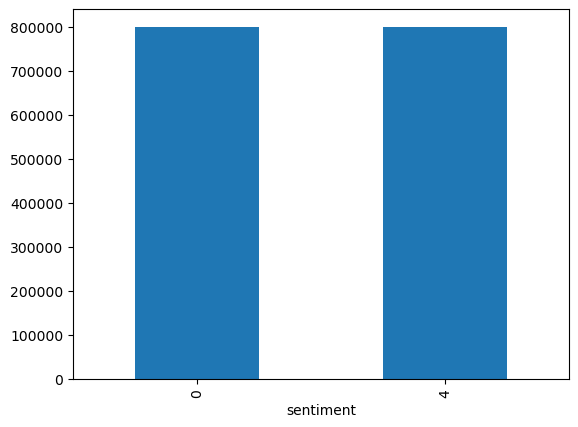

In [2]:
df.info()
# plot all values in the sentiment column
df['sentiment'].value_counts().plot(kind='bar')

In [3]:
import spacy
from tqdm import tqdm
import re

def extract_text(df, n_samples = None):
    # extract the text column from the dataframe for the first n_samples, ignore nan but make sure there are still n_samples
    if n_samples is None or n_samples >= len(df):
        n_samples = len(df)
    text = df['text'][:n_samples].dropna()
    if len(text) < n_samples:
        # if there are less than n_samples, we need to extract more
        # starting from the n_samples+1 until we have n_samples that are not nan
        for i in range(n_samples+1, len(df)):
            if not pd.isna(df['text'][i]):
                text = pd.concat([text, df['text'][i]])
                if len(text) >= n_samples:
                    break
    return text


def clean_text(text):
    nlp = spacy.load('en_core_web_sm')
    def remove_special_characters(text):
        print('Removing special characters...')
        # add a tqdm progress bar
        for i in tqdm(range(len(text))):
            doc = nlp(text[i])
            # remove special \n and \t
            text[i] = text[i].replace('\n', ' ').replace('\t', ' ')
            # make sure all words are separated by a single space
            # remove multiple spaces
            
            # remove kttp links
            text[i] = re.sub(r'http\S+', '', text[i])
            # remove everything after @
            text[i] = re.sub(r'@\S+', '', text[i])
            text[i] = ' '.join(text[i].split())
        return text
    text = remove_special_characters(text)
    return text

def extract_sentiment(df, n_samples = None):
    mapping = {'Positive': 0, 'Negative': 1}
    return mapping, df['sentiment'][:n_samples]

In [11]:
# shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

text = extract_text(df, 8000)
text = clean_text(text)
text[0]
mapping, sentiment = extract_sentiment(df, 8000)

Removing special characters...


100%|██████████| 8000/8000 [01:15<00:00, 105.42it/s]


In [12]:
inversed_mapping = {v: k for k, v in mapping.items()}
# change each 4 to 1
for i in range(len(sentiment)):
    if sentiment[i] == 4:
        sentiment[i] = 1


In [13]:
sentiment.describe()
text.info()


<class 'pandas.core.series.Series'>
Index: 8000 entries, 0 to 7999
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
8000 non-null   object
dtypes: object(1)
memory usage: 383.0+ KB


In [14]:
for i, t in enumerate(text):
    if t == '':
        # if the text is empty, we remove it
        text = text.drop(i)
        sentiment = sentiment.drop(i)

In [15]:
# save the text and category to a csv
clean_df = pd.DataFrame({'text': text, 'sentiment': sentiment})
clean_df.to_csv('../data/processed/cleaned_tweets.csv', index=False)

# save the mapping to a json
import json
with open('../data/processed/category_mapping.json', 'w') as f:
    json.dump(mapping, f)
